In [1]:
# essentials
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import os, sys
from scipy.stats import gamma, beta

# bayesflow
sys.path.append(os.path.abspath(os.path.join('../../BayesFlow')))
from bayesflow.computational_utilities import simultaneous_ecdf_bands

In [2]:
sys.path.append("../src")
from helpers import build_distance_matrix
from macro_models import batched_gaussian_process
from priors import diffusion_prior, length_scale_prior
from micro_models import dynamic_batch_diffusion, fast_dm_simulate, diffusion_trial
from networks import DynamicGaussianNetwork
from context import generate_design_matrix
from transformations import unscale_z, scale_z

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
print(tf.config.list_physical_devices('GPU'))

# physical_devices = tf.config.list_physical_devices('CPU')
# tf.config.set_visible_devices([], 'GPU')
# os.environ["CUDA_VISIBLE_DEVICES"]="-1" 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-11-14 11:50:02.585517: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 11:50:02.609773: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 11:50:02.609902: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [21]:
N_OBS         = 3200
N_PARAMS      = 6
N_SBC         = 2000
N_SAMPLES_SBC = 200

DIST_MAT = build_distance_matrix(N_OBS)
AMPLITUDES = [0.15, 0.15, 0.15, 0.15, 0.1, 0.05]

TIME_SLICES = np.array([800, 1600, 2400, 3200]) - 1

In [22]:
MACRO_MEAN = [5.0, 5.0, 5.0, 5.0, 5.0, 5.0]
MACRO_STD = [2.8, 2.8, 2.8, 2.8, 2.8, 2.8]

MICRO_MEAN = [1.3, 1.3, 1.3, 1.3, 1.3, 0.3]
MICRO_STD = [1.0, 1.0, 1.0, 1.0, 0.75, 0.25]

In [6]:
def generator_fun(batch_size):
    theta0 = diffusion_prior(batch_size, n_cond=N_PARAMS-2)
    eta = length_scale_prior(batch_size, N_PARAMS)
    theta_t = batched_gaussian_process(theta0, DIST_MAT, eta, amplitudes=AMPLITUDES)
    context = generate_design_matrix(batch_size, N_OBS)

    rt = dynamic_batch_diffusion(theta_t, context)
    x = np.concatenate((rt, to_categorical(context[:, :, np.newaxis])), axis=-1)

    eta_z = scale_z(eta, MACRO_MEAN, MACRO_STD)
    theta_t_z = scale_z(theta_t, MICRO_MEAN, MICRO_STD)

    return eta_z.astype(np.float32), theta_t_z.astype(np.float32), x.astype(np.float32)

In [7]:
network_settings = {
    'embedding_gru_units': 256,
    'embedding_lstm_units' : 256,
    'dense_pre_args': dict(units=256, activation='selu', kernel_initializer='lecun_normal'),
    'dense_micro_args': dict(units=128, activation='selu', kernel_initializer='lecun_normal'),
    'dense_macro_args': dict(units=128, activation='selu', kernel_initializer='lecun_normal'),
    'macro_lstm_units': 128,
    'n_micro_params': 6,
    'n_macro_params': 6
}
network = DynamicGaussianNetwork(network_settings)

In [8]:
network.load_weights('../trained_networks/gp_ddm_3200_joint_offline_factorized_new')

## SBC

In [ ]:
%%time
# generate data
eta_z, theta_t_z, data = generator_fun(N_SBC)
print(eta_z.shape)
print(theta_t_z.shape)
print(data.shape)

In [ ]:
# np.save('../saved_arrays/eta_z_sbc.npy', eta_z)
# np.save('../saved_arrays/theta_t_z_sbc.npy', theta_t_z)
# np.save('../saved_arrays/data_sbc.npy', data)

In [9]:
eta_z = np.load('../saved_arrays/eta_z_sbc.npy')
theta_t_z = np.load('../saved_arrays/theta_t_z_sbc.npy')
data = np.load('../saved_arrays/data_sbc.npy')
print(eta_z.shape)
print(theta_t_z.shape)
print(data.shape)

(2000, 6)
(2000, 3200, 6)
(2000, 3200, 5)


In [10]:
n_chunks = 500
chunk_len = int(data.shape[0] / n_chunks)
chunk_len

4

In [11]:
%%time
counter = 0
theta_z_pred = np.zeros((N_SAMPLES_SBC, N_SBC, len(TIME_SLICES), N_PARAMS))
eta_z_pred = np.zeros((N_SAMPLES_SBC, N_SBC, N_PARAMS))
for x in tf.split(data, n_chunks, axis=0):
    post = network.sample_n(x, N_SAMPLES_SBC)
    theta_z_pred[:, counter*chunk_len:(counter+1)*chunk_len] = post[1].numpy()[:, :, TIME_SLICES, :]
    eta_z_pred[:, counter*chunk_len:(counter+1)*chunk_len] = post[0].numpy()
    print(counter)
    counter += 1

2022-11-14 11:50:10.295343: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [23]:
theta_pred = unscale_z(theta_z_pred, MICRO_MEAN, MICRO_STD)
theta_true = unscale_z(theta_t_z, MICRO_MEAN, MICRO_STD)

eta_pred = unscale_z(eta_z_pred, MACRO_MEAN, MACRO_STD)
eta_true = unscale_z(eta_z, MACRO_MEAN, MACRO_STD)

theta_pred_sbc = np.transpose(theta_pred, (1, 0, 2, 3))

theta_pred_means = np.mean(theta_pred, axis=0)
theta_pred_stds = np.std(theta_pred, axis=0)
eta_pred_mean = np.mean(eta_pred, axis=0)
eta_pred_std = np.std(eta_pred, axis=0)

In [24]:
print(theta_pred.shape)

(200, 2000, 4, 6)


In [ ]:
# np.save('../saved_arrays/theta_pred.npy', theta_pred)
# np.save('../saved_arrays/theta_sim.npy', theta_sim)

In [25]:
import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Palatino"
matplotlib.rcParams['font.family'] = "sans-serif"

FONT_SIZE_1 = 20
FONT_SIZE_2 = 20
FONT_SIZE_3 = 18
FONT_SIZE_4 = 16

PARAM_LABELS = ['Drift rate 1', 'Drift rate 2', 'Drift rate 3', 'Drift rate 4', 'Threshold', 'Non-decision time']
PARAM_NAMES  = [r'$v_1$', r'$v_2$', r'$v_3$', r'$v_4$', r'$a$', r'$\tau$']

In [26]:
# theta_pred = np.load('../saved_arrays/theta_pred.npy')
# theta_sim = np.load('../saved_arrays/theta_sim.npy')

In [27]:
def plot_sbc_ecdf(post, prior, fill_color='grey', difference=True, **kwargs):

    fig = plt.figure(figsize=(19, 16), constrained_layout=True)

    # create 4x1 subfigs
    subfigs = fig.subfigures(nrows=len(TIME_SLICES), ncols=1)
    for row, subfig in enumerate(subfigs):
        subfig.suptitle(f'$t = {(TIME_SLICES+1)[row]}$', fontsize=FONT_SIZE_1, fontweight='bold')

        post_samples = post[:, :, row, :]
        prior_samples = prior[:, TIME_SLICES[row], :]

        # Store reference to number of parameters
        n_params = post_samples.shape[-1]
        
        # Compute fractional ranks (using broadcasting)    
        ranks = np.sum(post_samples < prior_samples[:, np.newaxis, :], axis=1) / post_samples.shape[1]

        # Compute uniform ECDF and bands
        alpha, z, L, H = simultaneous_ecdf_bands(post_samples.shape[0], **kwargs.pop('ecdf_bands_kwargs', {}))

        if difference:
            L -= z
            H -= z

        # create 1x6 subplots per subfig
        axs = subfig.subplots(nrows=1, ncols=6)
        for col, ax in enumerate(axs):
            ecdf_single = np.sort(ranks[:, col])
            xx = ecdf_single
            yy = np.arange(1, xx.shape[-1]+1)/float(xx.shape[-1])
            
            if difference:
                yy -= xx
            
            if col == 0:
                ax.plot(xx, yy, color='#852626', alpha=0.8, label='Rank ECDF', lw=1)
                ax.fill_between(z, L, H, color=fill_color, linewidth=0, alpha=0.3, label=f'{int((1-alpha) * 100)}% Confidence Bands')
            else:
                ax.plot(xx, yy, color='#852626', alpha=0.8, lw=1)
                ax.fill_between(z, L, H, color=fill_color, linewidth=0, alpha=0.3)

            # ax.grid(alpha=0.2)
            ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_4)
            sns.despine(ax=ax)

            if row == 0:
                ax.set_title(PARAM_LABELS[col] + ' ({})'.format(PARAM_NAMES[col]), fontsize=FONT_SIZE_2)
                if col == 0:
                    ax.set_xlabel('Fractional rank statistic', fontsize=FONT_SIZE_3)
                    if difference:
                        ylab = 'ECDF difference'
                    else:
                        ylab = 'ECDF'
                    ax.set_ylabel(ylab, fontsize=FONT_SIZE_3)
            else:
                ax.set_title(' ', fontsize=FONT_SIZE_2)
                if col == 0:
                    ax.set_xlabel(' ', fontsize=FONT_SIZE_3)
                    ax.set_ylabel(' ', fontsize=FONT_SIZE_3)


    subfigs[3].legend(fontsize=FONT_SIZE_3, bbox_to_anchor=(0.5, -0.05), loc='center', ncol=2)

    plt.savefig("../plots/sbc_gpddm.pdf", dpi=300, bbox_inches="tight")

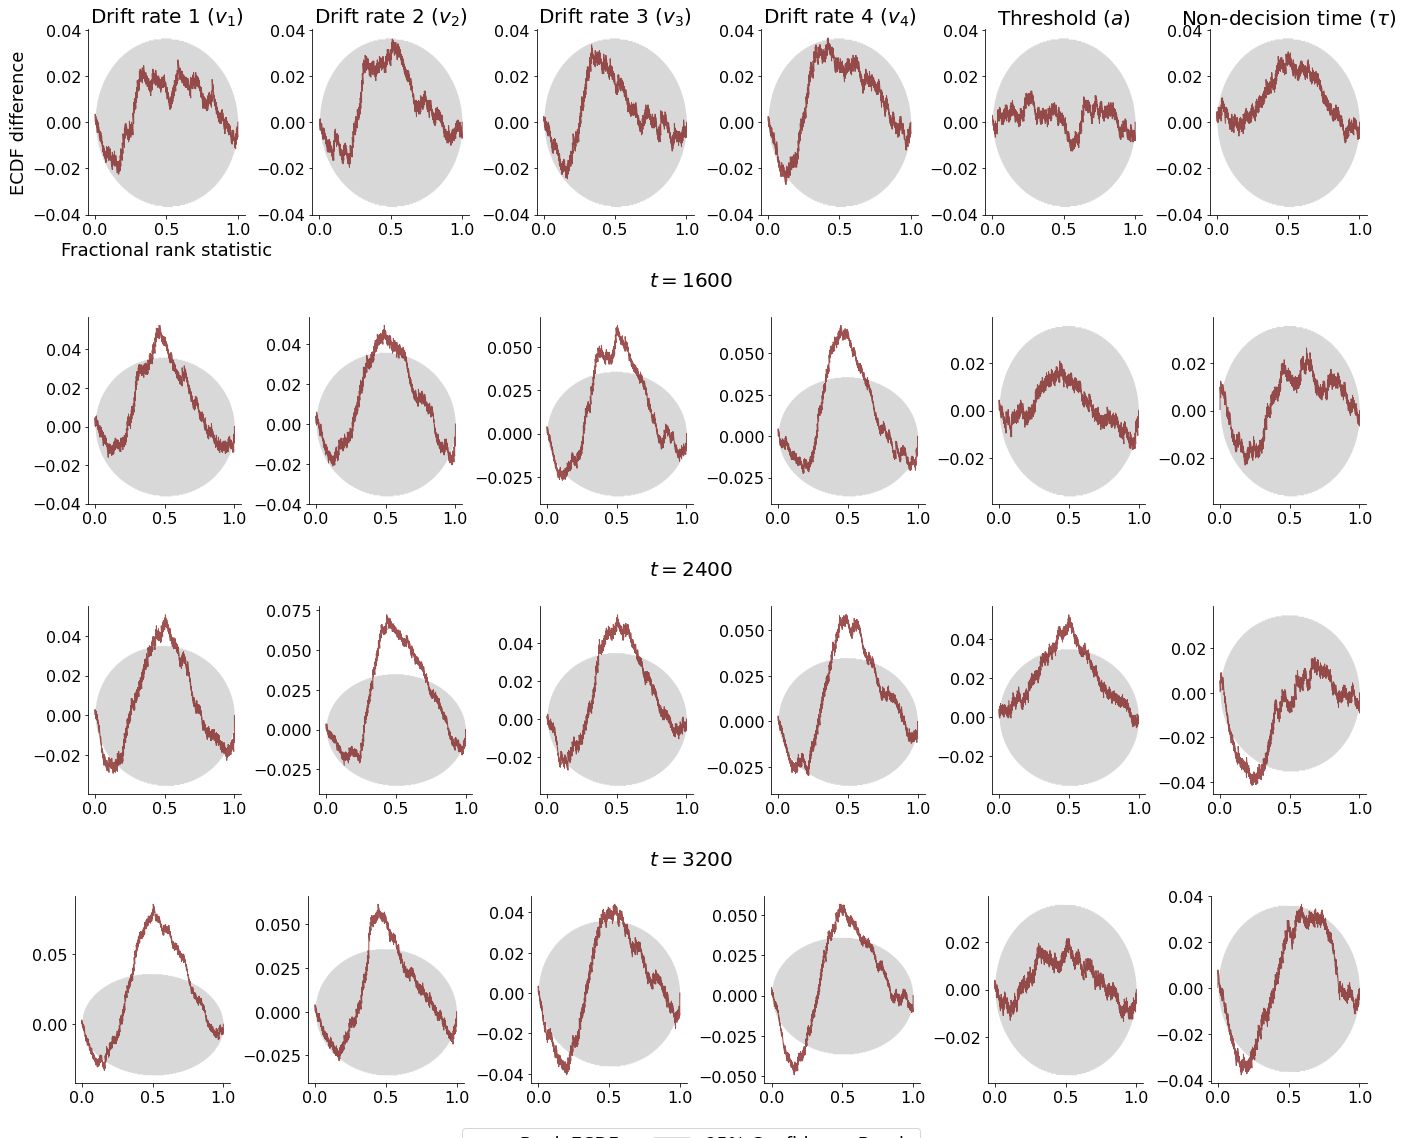

In [28]:
plot_sbc_ecdf(theta_pred_sbc, theta_true)